In [573]:
import deslib
import numpy as np
import deslib
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from deslib.dcs import MLA, Rank, LCA, APosteriori, APriori, BaseDCS, OLA
from deslib.des import KNORAU, METADES, DESP, KNORAE
import logging
from hdtree import *
from typing import Optional, Dict, List, Union
from sklearn.metrics import accuracy_score
from diss_eval.settings import DATA_PATH, KEEL_PATH
import diss_eval.settings as paths
import pandas as pd
from os.path import join as pjoin
from sklearn.datasets import fetch_openml
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
import os
from sklearn import tree
import graphviz
import datetime
import time
from collections import namedtuple
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from gon import GON
from typing import List
from scipy.stats import pearsonr
from aix360.algorithms.rbm import BRCGExplainer, BooleanRuleCG
from aix360.algorithms.rbm import FeatureBinarizer
from lib import prep_onthology_dataset
import wittgenstein as lw
from gon_viz import *
from sklearn.tree import plot_tree
from lib import NodeRecord, RunEval, PATH_PAPER, PATH_PAPER_FIGS,  get_leaf_depths_sklearn_tree
from sklearn.tree import _tree
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV 
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
logging.getLogger().setLevel(logging.DEBUG)

In [3]:
hsmw_blue = "#2a6bb7"
hsmw_orange = "#E97817"
tuc_green = "#6a8a26"

font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 13}

matplotlib.rc('font', **font)
standard_cmap = 'pastell'
sns.set_style("whitegrid")

In [4]:
df_cancer = pd.read_csv(pjoin('datasets', 'uci_cancer.csv'))

In [5]:
df_cancer.head(1)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38           122.8     1001.0           0.1184   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0            0.2776          0.3001               0.1471         0.2419   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0                 0.07871  ...          17.33            184.6      2019.0   

   worst smoothness  worst compactness  worst concavity  worst concave points  \
0            0.1622             0.6656           0.7119                0.2654   

   worst symmetry  worst fractal dimension     target  
0          0.4601                   0.1189  malignant  

[1 rows x 31 columns]

In [6]:
df_cancer['target'].value_counts()

benign       357
malignant    212
Name: target, dtype: int64

In [7]:
y_breast_binarized_pos_malignant = np.array([*map(lambda lbl: 1. if lbl == 'malignant' else 0., 
                                    df_cancer.iloc[:, -1].values)], dtype=np.bool)

In [8]:
X_breast_bin = FeatureBinarizer(negations=True, numThresh=10).fit_transform(df_cancer.iloc[:, :-1])

In [94]:
X_train_breast, X_test_breast, y_train_breast, y_test_breast, X_train_breast_binarized, X_test_breast_binarized, y_train_breast_binarized_pos_malignant, y_test_breast_binarized_pos_malignant = \
                                                                                train_test_split(
                                                                                    df_cancer.iloc[:, :-1], 
                                                                                    df_cancer.iloc[:, -1],
                                                                                    X_breast_bin,
                                                                                    y_breast_binarized_pos_malignant,
                                                                                    test_size=0.33, 
                                                                                    random_state=42)

In [95]:
X_train_breast.head(1)

mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
172        15.46         11.89           102.5      736.9           0.1257   

     mean compactness  mean concavity  mean concave points  mean symmetry  \
172            0.1555          0.2032               0.1097         0.1966   

     mean fractal dimension  ...  worst radius  worst texture  \
172                 0.07069  ...         18.79          17.04   

     worst perimeter  worst area  worst smoothness  worst compactness  \
172            125.0      1102.0            0.1531             0.3583   

     worst concavity  worst concave points  worst symmetry  \
172            0.583                0.1827          0.3216   

     worst fractal dimension  
172                    0.101  

[1 rows x 30 columns]

## RIPPER

In [96]:
import wittgenstein
import re

class RipperAdapterRuleset():
    
    REGEX_TWO_NUMBERS_WITH_MINUS_BETWEEN = r'([+\-]?[0-9]+\.[0-9]+)-([+\-]?[0-9]+\.[0-9]+)'
    REGEX_TWO_NUMBERS_WITH_MINUS_BETWEEN_COMPILED = re.compile(REGEX_TWO_NUMBERS_WITH_MINUS_BETWEEN)
    
    def get_pandas_query_string(self, cond: wittgenstein.base.Cond) -> str:
        """
        Will regturn a string that can be used in pandas.query
        has the form lower_value <= `field_name` <= upper_value
        :return:
        """
        val = cond.val
        feature = cond.feature
        matches = self.REGEX_TWO_NUMBERS_WITH_MINUS_BETWEEN_COMPILED.match(val)
        if matches is None:
            raise Exception("Only rules with patterns num1-num2 are supported atm (Code: 2348723842)")

        try:
            num_1 = matches[1]
            num_2 = matches[2]

            num_1_float = float(num_1)
            num_2_float = float(num_2)

            return f"{num_1_float-0.005} < `{feature}` <= {num_2_float+0.0049}"
        
        except IndexError:
            raise Exception("Numbers could not be found by regex. Pattern: num1-num2 (Code: 324982390)")
            
        except ValueError:
            raise Exception(f"Could't parse the matches strings to numbers (Code: 0932482930)")
    
    def __init__(self, ripper: lw.RIPPER):
        self.rule_set = ripper.ruleset_
        self.ripper = ripper
        
    def count_conditions(self):
        i = 0
        for rule in self.rule_set:
            for clause in rule.conds:
                i+=1
                
        return i
    
    def count_rules(self):
        return len(self.rule_set)
    
    def calc_avg_rule_length(self):
        return self.count_conditions() / self.count_rules()
    
    
    def get_covered_samples(self, df: pd.DataFrame):
        
        """
        covered_ids = []
        for rule in self.rule_set.rules:
            
            # get samples matching all conditions
            # covered = df.query(self.get_pandas_query_string(cond=rule.conds[0]))
            queries = []
            for cond in rule.conds:
                queries.append(self.get_pandas_query_string(cond=cond))
            query_str = '('+') and ('.join(queries)+')'
            #print(query_str)
            working_indices = [*df.query(query_str).index]
            #print(working_indices)
            covered_ids += working_indices
            
        """
        cpy = df.copy()
        wittgenstein.base.bin_transform(cpy, self.ripper.bin_transformer_)
        covered_ids= self.rule_set.covers(cpy).index.tolist()
        return df.loc[[*set(covered_ids)], :]


In [12]:
ripper_breast_malignant = lw.RIPPER(verbosity=0)

In [13]:
ripper_breast_benign = lw.RIPPER(verbosity=0)

In [15]:
ripper_breast_malignant.fit(X_train_breast.copy(), y_train_breast.copy(), 
                  pos_class='malignant', n_discretize_bins=10)

In [16]:
ripper_breast_benign.fit(X_train_breast.copy(), y_train_breast, 
                  pos_class='benign', n_discretize_bins=10)

In [56]:
print("Malignant Rules\n---------------------")
ripper_breast_malignant.ruleset_.out_pretty()

Malignant Rules
---------------------
[[meanconcavity=0.16-0.21] V
[meanconcavity=0.12-0.16^fractaldimensionerror=0.0-0.0] V
[meanconcavity=0.09-0.12^fractaldimensionerror=0.0-0.0^meanconcavepoints=0.05-0.07] V
[meanconcavity=0.22-0.43] V
[meanconcavepoints=0.07-0.09] V
[worstarea=971.4-1332.0] V
[meantexture=21.41-22.49^symmetryerror=0.01-0.01] V
[worstperimeter=119.4-140.9] V
[meantexture=22.53-25.44^meansmoothness=0.09-0.1]]


In [45]:
print("Malignant Score\n---------------------")
ripper_breast_malignant.score(X_train_breast, y_train_breast), ripper_breast_malignant.score(X_test_breast, y_test_breast)

Malignant Score
---------------------


(0.9553805774278216, 0.9521276595744681)

In [90]:
print("Benign Score\n---------------------")
ripper_breast_benign.score(X_train_breast, y_train_breast), ripper_breast_benign.score(X_test_breast, y_test_breast)

Benign Score
---------------------


(0.931758530183727, 0.898936170212766)

In [46]:
print("Benign Rules\n---------------------")
ripper_breast_benign.ruleset_.out_pretty()

Benign Rules
---------------------
[[concavepointserror=0.01-0.01^meanconcavity=0.03-0.04] V
[meanconcavity=0.01-0.03] V
[meanconcavity=0.04-0.05] V
[meanconcavity=0.05-0.07] V
[worstconcavity=0.0-0.04] V
[meantexture=9.71-14.16] V
[meanconcavity=0.07-0.09^meanconcavepoints=0.03-0.04] V
[worstperimeter=86.7-91.62] V
[meanconcavepoints=0.02-0.03] V
[worstradius=14.11-14.99] V
[meanconcavepoints=0.02-0.02] V
[meansmoothness=0.06-0.08] V
[meanradius=10.51-11.45]]


In [84]:
print("Coverage Malignant")
ripper_adapter_malignant = RipperAdapterRuleset(ripper=ripper_breast_malignant)
n_covered_test = len(ripper_adapter_malignant.get_covered_samples(X_test_breast))
n_covered_train = len(ripper_adapter_malignant.get_covered_samples(X_train_breast))
n_covered_train/len(X_train_breast), \
n_covered_test/len(X_test_breast)

Coverage Malignant


(0.3989501312335958, 0.3617021276595745)

In [89]:
print("Coverage Benign")
ripper_adapter_benign = RipperAdapterRuleset(ripper=ripper_breast_benign)
n_covered_test = len(ripper_adapter_benign.get_covered_samples(X_test_breast))
n_covered_train = len(ripper_adapter_benign.get_covered_samples(X_train_breast))
n_covered_train/len(X_train_breast), \
n_covered_test/len(X_test_breast)

Coverage Benign


(0.6141732283464567, 0.6170212765957447)

In [19]:
print("Benign Score\n---------------------")
ripper_breast_benign.score(X_train_breast, y_train_breast), ripper_breast_benign.score(X_test_breast, y_test_breast)

Benign Score
---------------------


(0.931758530183727, 0.898936170212766)

In [87]:
print("Avg Rule condition Malignant")
ripper_adapter_malignant.calc_avg_rule_length(), ripper_adapter_malignant.count_rules()

Avg Rule condition Malignant


(1.5555555555555556, 9)

In [88]:
print("Avg Rule condition benign")
ripper_adapter_benign.calc_avg_rule_length(), ripper_adapter_benign.count_rules()

Avg Rule condition benign


(1.1538461538461537, 13)

## BRCG

In [237]:
class BRCGWrapper():
    """
    model.z -> Each column presents a combination of rules. The rules are the index(!) of z where the value is not 0;
            -> (n_clauses x n_rules)
    model.w -> index which rules are chosen in the system 
            -> (n_rules)
    """
    def __init__(self, brcg: BRCGExplainer):
        self.brcg_explainer = brcg
        self.model: BooleanRuleCG = self.brcg_explainer._model
        
    def get_chosen_rules(self) -> pd.DataFrame:
        return self.model.z.loc[:, self.model.w > 0.5]
        
    def count_rules(self) -> int:
        return self.get_chosen_rules().shape[1]
    
    def count_conditions(self) -> int:
        return self.get_chosen_rules().sum().sum()
    
    def calc_avg_rule_length(self) -> float:
        return self.count_conditions() / self.count_rules()
    
    def get_covered_samples(self, df_binarized: pd.DataFrame):
        # please never ask me what I did here ever again
        chosen_rules = self.get_chosen_rules()
        num_matching_conditions = df_binarized.dot(chosen_rules)
        difference_to_needed_rules = num_matching_conditions - chosen_rules.sum(axis=0)
        is_covered_by_rule = difference_to_needed_rules == 0
        is_covered_by_at_least_one_rule = is_covered_by_rule.sum(axis=1) > 0
        
        #chosen_rules = wrapper_brcg_pos_malignant.get_chosen_rules()
        #oks = (X_train_breast_binarized.dot(chosen_rules)-chosen_rules.sum(axis=0) == 0).sum(axis=1) > 0
        #X_train_breast_binarized.loc[oks[oks].index]
        
        return df_binarized.loc[is_covered_by_at_least_one_rule[is_covered_by_at_least_one_rule].index]
            

In [91]:
brcg_breast_pos_malignant = BooleanRuleCG(silent=True)
brcg_breast_explainer_pos_malignant = BRCGExplainer(brcg_breast_pos_malignant)
brcg_breast_explainer_pos_malignant.fit(X_train_breast_binarized, y_train_breast_binarized_pos_malignant)

brcg_breast_pos_benign = BooleanRuleCG(silent=True)
brcg_breast_explainer_pos_benign = BRCGExplainer(brcg_breast_pos_benign)
brcg_breast_explainer_pos_benign.fit(X_train_breast_binarized, ~y_train_breast_binarized_pos_malignant)

In [245]:
wrapper_brcg_pos_malignant = BRCGWrapper(brcg=brcg_breast_explainer_pos_malignant)
wrapper_brcg_pos_benign = BRCGWrapper(brcg=brcg_breast_explainer_pos_benign)

In [92]:
print("BRCG Pos Malignant\n-----------------------")
isCNF = 'Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:'
notCNF = 'Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:'
print(isCNF if brcg_breast_explainer_pos_malignant.explain()['isCNF'] else notCNF)
print()
for rule in brcg_breast_explainer_pos_malignant.explain()['rules']:
    print(f'  - {rule}')

BRCG Pos Malignant
-----------------------
Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:

  - worst texture > 27.28 AND worst concave points > 0.13
  - worst area > 988.68 AND worst concavity > 0.19
  - worst radius > 12.36 AND worst concave points > 0.16
  - radius error > 0.57 AND fractal dimension error <= 0.00
  - mean texture > 18.40 AND smoothness error > 0.00 AND worst area > 826.18


In [238]:
print("BRCG Pos Benign\n-----------------------")
isCNF = 'Predict Y=0 if ANY of the following rules are satisfied, otherwise Y=1:'
notCNF = 'Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:'
print(isCNF if brcg_breast_explainer_pos_benign.explain()['isCNF'] else notCNF)
print()
for rule in brcg_breast_explainer_pos_benign.explain()['rules']:
    print(f'  - {rule}')

BRCG Pos Benign
-----------------------
Predict Y=1 if ANY of the following rules are satisfied, otherwise Y=0:

  - mean radius <= 10.18
  - mean texture <= 16.48 AND mean concavity <= 0.12
  - perimeter error <= 4.01 AND worst concavity <= 0.19
  - mean concave points <= 0.04 AND radius error <= 0.57 AND worst texture <= 29.11 AND worst perimeter <= 121.22
  - perimeter error > 1.49 AND symmetry error > 0.01 AND worst area <= 719.64 AND worst compactness > 0.09 AND worst concave points <= 0.18


In [239]:
print("Score BRCG Pos Malignant\n-----------------------")
accuracy_score(brcg_breast_explainer_pos_malignant.predict(X_train_breast_binarized), 
               y_train_breast_binarized_pos_malignant), accuracy_score(brcg_breast_explainer_pos_malignant.predict(X_test_breast_binarized), 
               y_test_breast_binarized_pos_malignant)

Score BRCG Pos Malignant
-----------------------


(0.989501312335958, 0.9521276595744681)

In [240]:
print("Score BRCG Pos Benign\n-----------------------")
accuracy_score(brcg_breast_explainer_pos_benign.predict(X_train_breast_binarized), 
               ~y_train_breast_binarized_pos_malignant), accuracy_score(brcg_breast_explainer_pos_benign.predict(X_test_breast_binarized), 
               ~y_test_breast_binarized_pos_malignant)

Score BRCG Pos Benign
-----------------------


(0.994750656167979, 0.9202127659574468)

In [242]:
print("# Rule malignant, avg rule length")
wrapper_brcg_pos_malignant.count_rules(), wrapper_brcg_pos_malignant.calc_avg_rule_length()

# Rule malignant, avg complexity


(5, 2.2)

In [246]:
print("# Rule benign, avg rule length")
wrapper_brcg_pos_benign.count_rules(), wrapper_brcg_pos_benign.calc_avg_rule_length()

# Rule benign, avg rule length


(5, 2.8)

In [248]:
print("Coverage malignant")
len(wrapper_brcg_pos_malignant.get_covered_samples(X_train_breast_binarized))/len(X_train_breast_binarized), \
len(wrapper_brcg_pos_malignant.get_covered_samples(X_test_breast_binarized))/len(X_test_breast_binarized)

Coverage malignant


(0.3700787401574803, 0.35106382978723405)

In [249]:
print("Coverage benign")
len(wrapper_brcg_pos_benign.get_covered_samples(X_train_breast_binarized))/len(X_train_breast_binarized), \
len(wrapper_brcg_pos_benign.get_covered_samples(X_test_breast_binarized))/len(X_test_breast_binarized)

Coverage benign


(0.6141732283464567, 0.6276595744680851)

## GoN

In [488]:
# GON
trees_cancer = [HDTreeClassifier(allowed_splits=[# SmallerThanSplit,
                            FixedValueSplit,
                            TenQuantileRangeSplit.build_with_restrictions(max_level=1),
                            TenQuantileSplit.build_with_restrictions(max_level=0),
                            TwentyQuantileRangeSplit.build_with_restrictions(min_level=2),
                            TwentyQuantileSplit.build_with_restrictions(min_level=1),
                            ],
                        min_samples_at_leaf=5,
                        information_measure=EntropyMeasure(),
                        attribute_names=df_cancer.columns[:-1],
                        max_levels=1, 
                        verbose=False) for i in range(9)]

In [489]:
gon_cancer = GON(pool_classifiers=trees_cancer,
                  DSEL_perc=0.,
                  step_size=2,
                  iterations=20,
                  max_jobs=1,
                  val_perc=0.0,
                  maximum_selected_features=11,
                  random_state=42)

In [490]:
gon_cancer.fit(X_train_breast.values, 
               y_train_breast.values, 
               X_expert=X_train_breast.values)

In [511]:
gon_cancer.score(X_train_breast.values, y_train_breast.values, X_train_breast.values), \
gon_cancer.score(X_test_breast.values, y_test_breast.values, X_test_breast.values)

(0.9658792650918635, 0.9414893617021277)

In [506]:
gon_cancer.remove_model(7)
#gon_cancer.pool_classifiers_[0].get_allowed_splits()[-1].add_blacklist_entry('worst concavity')
#gon_cancer.pool_classifiers_[0].set_min_leaf_samples(3)
#gon_cancer.pool_classifiers_[0].add_allowed_split(TwentyQuantileSplit)

In [507]:
gon_cancer.refit_nerds()

In [445]:
#gon_cancer.pool_classifiers_[1].get_allowed_splits()[4].clear_blacklist_entries()

In [455]:
gon_cancer.pool_classifiers_[1].get_allowed_splits()[2].get_name()

'TenQuantileSplit'

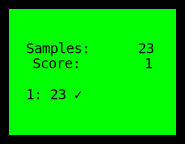

In [640]:
gon_cancer.pool_classifiers_[7].generate_dot_graph()

In [517]:
print("Gon Score Final")
gon_cancer.score(X_train_breast.values, y_train_breast.values, X_train_breast.values), \
gon_cancer.score(X_test_breast.values, y_test_breast.values, X_test_breast.values)

Gon Score Final


(0.9658792650918635, 0.9414893617021277)

In [532]:
rule_gon_cancer = GonRuleLearner.from_gon_instance(gon_cancer, 
                                                  max_length_assignment=2, 
                                                  min_precision=0.5,
                                                  min_coverage=0.02)

In [534]:
pd.set_option('display.max_colwidth', 100)
rule_gon_cancer.explain()

Rule 1  \
0                             worst radius ≥ 20.42   
1   mean radius is INSIDE range [15.10, ... 19.53[   
2                             mean texture ≥ 16.45   
3                          worst smoothness ≥ 0.14   
4   mean radius is INSIDE range [15.10, ... 19.53[   
5                           mean perimeter < 78.99   
6  worst radius is INSIDE range [13.83, ... 15.14[   
7   mean radius is INSIDE range [12.04, ... 13.20[   
8                          worst smoothness < 0.14   
9                             mean texture < 16.45   

                                                 Rule 2  Coverage in Percent  \
0                                                                      20.21   
1       worst radius is INSIDE range [17.34, ... 20.96[                 9.45   
2  worst perimeter is INSIDE range [109.50, ... 126.90[                 9.19   
3  worst perimeter is INSIDE range [101.55, ... 109.30[                 2.62   
4       worst radius is INSIDE range [20.96, ... 21.86[                 2.10   
5                                                                      34.91   
6                                                                      14.96   
7     mean perimeter is INSIDE range [78.02, ... 82.43[                 9.71   
8  worst perimeter is INSIDE range [101.55, ... 109.30[                 5.25   
9  worst perimeter is INSIDE range [109.50, ... 126.90[                 2.62   

   Precision in Percent Nerd Prediction  
0                100.00   #3  malignant  
1                 86.11   #8  malignant  
2                 82.86   #5  malignant  
3                100.00   #1  malignant  
4                100.00   #6  malignant  
5                 96.24   #2     benign  
6                 92.98   #7     benign  
7                 94.59   #4     benign  
8                 75.00   #1     benign  
9                 80.00   #5     benign

In [641]:
# attributes


In [535]:
print("Rule Predictor Scores")
rule_gon_cancer.score(X_train_breast.values, y_train_breast.values), \
rule_gon_cancer.score(X_test_breast.values, y_test_breast.values)

Rule Predictor Scores


(0.9422572178477691, 0.9627659574468085)

In [536]:
print("Rule Predictor Coverage")
rule_gon_cancer.calculate_rule_coverage(X_train_breast),\
rule_gon_cancer.calculate_rule_coverage(X_test_breast)

Rule Predictor Coverage


(0.9606299212598425, 0.9521276595744681)

In [537]:
print("Rule Predictor GoN Agreement")
rule_gon_cancer.calculate_agreement_with_gon(X=X_train_breast, X_expert=X_train_breast, gon=gon_cancer), \
rule_gon_cancer.calculate_agreement_with_gon(X=X_test_breast, X_expert=X_test_breast, gon=gon_cancer)

Rule Predictor GoN Agreement


(0.9763779527559056, 0.9361702127659575)

In [538]:
print("avg length")
rule_gon_cancer.calc_avg_rule_length(), \
rule_gon_cancer.count_rules()

avg length


(1.7, 10)

## Decison Tree

In [317]:
tree_cancer = DecisionTreeClassifier(min_samples_leaf=1, max_depth=None, ccp_alpha=0.01)

In [318]:
tree_cancer.fit(X_train_breast, y_train_breast)

DecisionTreeClassifier(ccp_alpha=0.01, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [319]:
print("Performance Decision Tree")
tree_cancer.score(X_train_breast, y_train_breast), \
tree_cancer.score(X_test_breast, y_test_breast)

Performance Decision Tree


(0.9711286089238845, 0.9574468085106383)

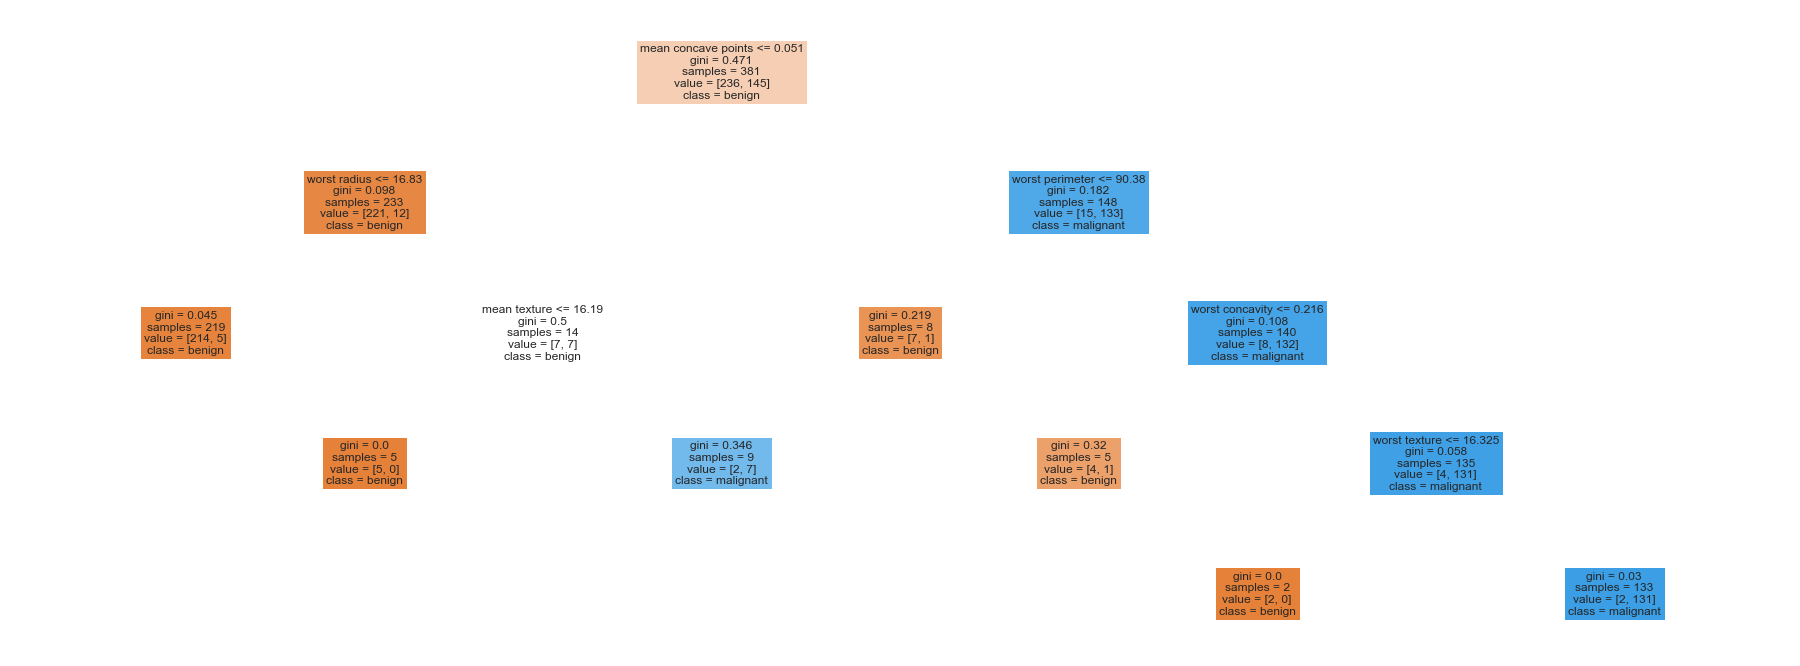

In [320]:
fig, ax = plt.subplots(1,1, figsize=(32,12))
_ = plot_tree(tree_cancer, feature_names=X_train_breast.columns, 
              class_names=['benign', 'malignant'], 
              filled=True, ax=ax, fontsize=12, )

In [570]:
leaf_depths = parse_sklearn_tree(tree_cancer)

In [572]:
len(leaf_depths), np.mean(leaf_depths)

(7, 3.0)

In [571]:
leaf_depths

[4, 4, 3, 2, 3, 3, 2]

## SVC

In [605]:
svc_breast = SVC()

In [607]:
svc_breast.fit(X_train_breast, y_train_breast)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [609]:
svc_breast.score(X_train_breast, y_train_breast), \
svc_breast.score(X_test_breast, y_test_breast)

(0.905511811023622, 0.9521276595744681)

## MLP

In [612]:
mlp_grid = {
    'hidden_layer_sizes': [(100,), (50,), (20,), (10,), (200,), (300,)],
    'max_iter': [500],
    'random_state': [42],
}

In [613]:
mlp_breast = MLPClassifier()

In [614]:
grid_mlp_breast = GridSearchCV(mlp_breast, param_grid=mlp_grid)

In [615]:
grid_mlp_breast.fit(X_train_breast, y_train_breast)

C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Richard\Anaconda3\envs\gonviz\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:568: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\Richard

GridSearchCV(cv=None, error_score=nan,
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_fun=15000,
                                     max_iter=200, momentum=0.9,
                                     n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='deprecated', n_jobs=None,
             param_gr

In [616]:
grid_mlp_breast.score(X_train_breast, y_train_breast), \
grid_mlp_breast.score(X_test_breast, y_test_breast)

(0.9422572178477691, 0.9521276595744681)

In [617]:
grid_mlp_breast.best_estimator_

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(200,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=42, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)